# Example: run MultiSolSegment and validate
This examples hows how to download the weights for MultiSolSegment, run it on an image to segment crack, dark and busbar masks. Then use pvimage to look at crack count and parameters

In [ ]:
from pathlib import Path
import os

project_root = Path.cwd().parents[1]
os.chdir(project_root)  # now cwd is .../pvcracks

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from pvcracks.utils import viz_functions, train_functions

import requests

from pvimage import features

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d44b50>>
Traceback (most recent call last):
  File "/Users/ojas/Desktop/saj/SANDIA/pvcracks_paper_revise/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


ModuleNotFoundError: No module named 'pvcracks'

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

## Step 1: Download Model

DOI - https://doi.org/10.21948/2997859  
Direct Link - https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt

In [ ]:
# if you have have already downloaded model weights, replace this with the local path
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty10/epoch_19/model.pt"
weight_path = "multisolsegment.pt"

if os.path.exists(weight_path):
    print("Weights already downloaded.")
else:
    response = requests.get(
        "https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt"
    )
    with open(weight_path, "wb") as f:
        f.write(response.content)

Weights already downloaded.


## Step 2: Download and Load Images

DOI - https://doi.org/10.21948/2587738  
Direct Link - https://datahub.duramat.org/dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/resource/8f12be45-b929-4f5c-9400-84dde27b0e90/download/labeledelcells.zip

In [ ]:
from zipfile import ZipFile
from io import BytesIO
import os

url = (
    "https://datahub.duramat.org/"
    "dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/"
    "resource/8f12be45-b929-4f5c-9400-84dde27b0e90/"
    "download/labeledelcells.zip"
)

out_dir = os.path.expanduser("labeled_image_data")
if os.path.exists(out_dir):
    print("Images already downloaded.")
else:
    os.makedirs(out_dir, exist_ok=True)
    
    resp = requests.get(url)
    resp.raise_for_status()  
    
    with ZipFile(BytesIO(resp.content)) as z:
        z.extractall(path=out_dir)

Images already downloaded.


In [ ]:
out_dir

'labeled_image_data'

## Step 3: Set local paths

In [ ]:
files_root = f"{out_dir}/LabeledELcells/"

## Step 4: Load in everything

In [ ]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

root = Path(files_root)
img_root = root / "img" / "all"

train_dataset, val_dataset = train_functions.load_dataset(root)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

## Step 5: Pick image and threshold

Index is what image to run this model on.  

Threshold is what confidence % we want to code as an actual detection target, rather than just background noise.

In [ ]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

idx = 7
threshold = 0.5  # default

## Step 6: Inference and Show

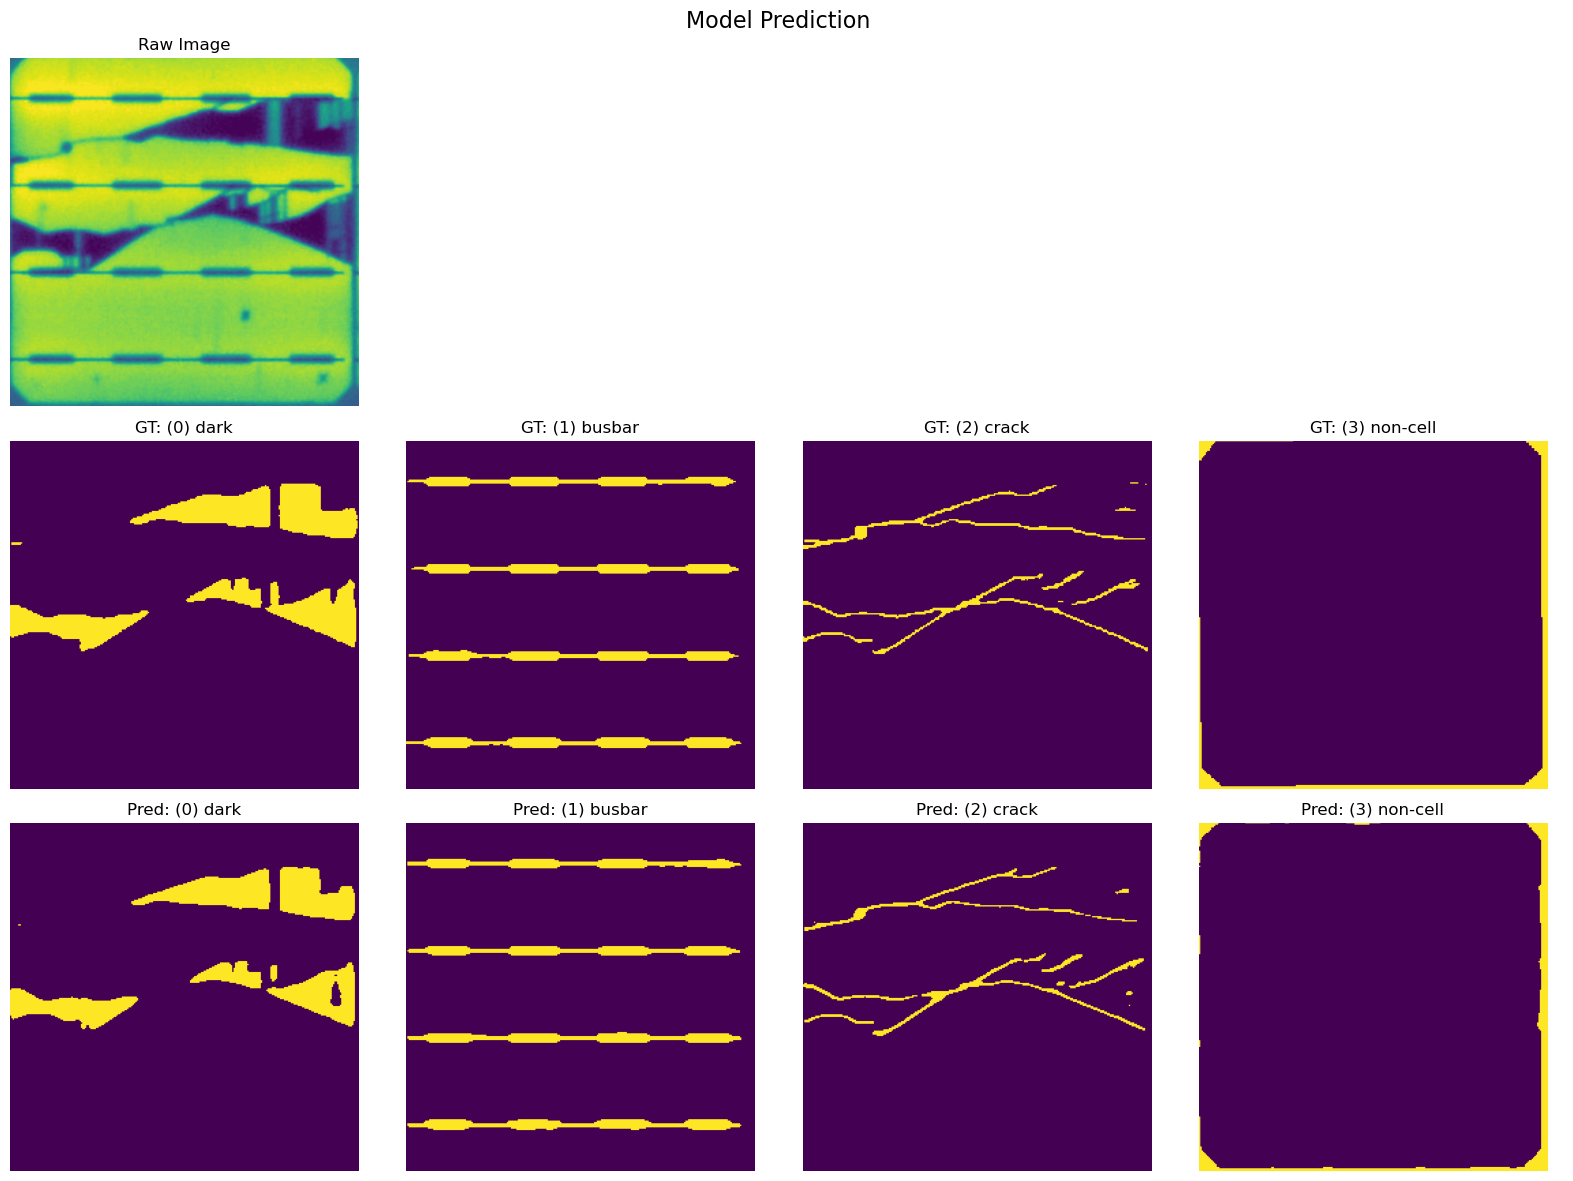

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_functions.channeled_inference_and_show(
    val_loader, device, model, category_mapping, idx, threshold, custom_title="MultiSolSegment Model Prediction"
)
plt.savefig("mss_model_prediction.png", dpi=300)

## Step 7: Investigate dark area %

In [ ]:
def channel_activation_percentages(mask, category_mapping):
    """
    Calculate the percentage of pixels activated for each channel in a multi-hot mask.

    Args:
        mask: 3D array-like of shape (n_channels, height, width) containing multi-hot activations.
        category_mapping (dict): Mapping from channel index to class name. The iteration order
            defines the channel order in the mask tensor.

    Returns:
        dict: Mapping from class name to percentage (0-100) of activated pixels in that channel.
    """

    mask_np = np.asarray(mask)

    if mask_np.ndim != 3:
        raise ValueError(
            f"Expected a 3D mask of shape (channels, height, width); got {mask_np.shape}."
        )

    n_channels, height, width = mask_np.shape
    total_pixels = height * width

    if total_pixels == 0:
        raise ValueError("Mask must contain at least one pixel.")

    percentages = {}
    for channel_idx, class_name in category_mapping.items():
        if channel_idx >= n_channels:
            raise ValueError(
                f"Channel index {channel_idx} for class '{class_name}' is out of bounds "
                f"for mask with {n_channels} channel(s)."
            )
        channel_activation = mask_np[channel_idx].sum()
        percentages[class_name] = (
            float(channel_activation) / float(total_pixels) * 100.0
        )

    return percentages


def print_channel_activation_percentages(percentages):
    print("Predicted channel activation (% of image):")
    sum = 0
    for _, class_name in category_mapping.items():
        print(f"\t{class_name}: {percentages[class_name]:.2f}%")
        sum += percentages[class_name]
    print("\tRemaining (solar cell): %.2f%%\n" % (100 - sum))

In [ ]:
img, mask = val_loader.dataset.__getitem__(idx)
img = img.to(device)
img_path = val_loader.dataset.__get_img_path__(idx)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)
pred_mask = (probs > threshold).float().squeeze(0).numpy()

gt_mask = mask.cpu().numpy()

gt_percentages = channel_activation_percentages(gt_mask, category_mapping)
pred_percentages = channel_activation_percentages(pred_mask, category_mapping)

print_channel_activation_percentages(gt_percentages)
print_channel_activation_percentages(pred_percentages)

Predicted channel activation (% of image):
	dark: 11.16%
	busbar: 7.75%
	crack: 3.05%
	non-cell: 3.70%
	Remaining (solar cell): 74.34%

Predicted channel activation (% of image):
	dark: 10.31%
	busbar: 7.81%
	crack: 3.08%
	non-cell: 3.70%
	Remaining (solar cell): 75.10%



## Step 8: Crack mask features with PVImage

Extract predicted crack masks, compute crack statistics with PVImage, and visualize the distribution of key metrics.


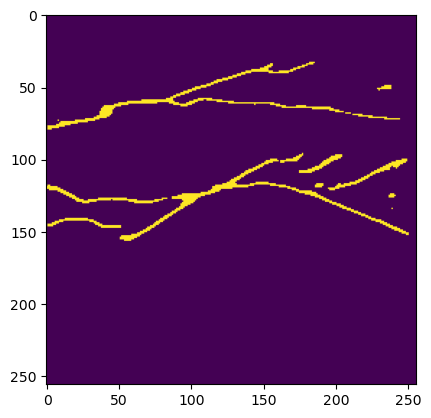

In [ ]:
img, mask = val_loader.dataset.__getitem__(idx)
img = img.to(device)
img_path = val_loader.dataset.__get_img_path__(idx)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)
pred_mask = (probs > threshold).float().squeeze(0).numpy()

fig, ax = plt.subplots()
ax.imshow(pred_mask[2], cmap="viridis")

In [ ]:
crack_mask = (pred_mask[2] * 255).astype(np.uint8)  # Convert [0,1] to [0,255]

# Create DataFrame with image path
dfinfo = pd.DataFrame()
dfinfo["impath"] = [str(img_path)]  # Wrap in list

# Run feature extraction
dffeaturesreal = features.feature_extraction_crack_mask([crack_mask], dfinfo)
dffeaturesreal.head()

,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_0540,4,745.404112,-2.728464,13499.0,5157.0,-1.459944
0,mxy_0540,0,332.468037,-1.693958,3134.0,1898.0,-1.429506
0,mxy_0540,2,149.59798,-1.927778,949.0,789.0,-1.273929


In [ ]:
def violinplt(data, palette=None, figsize=(5, 4), y_axis_log=False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Coerce to DataFrame so .mean() and column names behave
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=figsize)

    # Seaborn API: no widths/showmeans/showmedians/showextrema here
    # Use inner="quartile" to show quartiles; cut=0 to avoid extrapolation
    sns.violinplot(
        data=data,
        ax=ax,
        palette=palette,
        inner="quartile",
        cut=0,
        linewidth=1,
    )

    # Overlay means as points
    means = data.mean().to_numpy()
    x_pos = np.arange(len(means))
    ax.scatter(x_pos, means, zorder=3)

    # Prepare mean labels
    nobs = [f"{m:.2f}" for m in means]

    # Place mean labels slightly above the point
    y_offset = 0.03 * (
        np.nanmax(means) - np.nanmin(means) if np.all(np.isfinite(means)) else 1.0
    )
    if len(x_pos) > 3:
        for i in x_pos:
            t = ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="semibold",
            )
            # subtle white box for readability
            t.set_bbox(
                dict(
                    facecolor="white",
                    alpha=0.5,
                    edgecolor="none",
                    boxstyle="round,pad=0.15",
                )
            )
        # Rotate tick labels cleanly
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        for i in x_pos:
            ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                weight="semibold",
            )

    ax.set_ylabel("Value")
    ax.set_xlabel("")
    if y_axis_log:
        ax.set_yscale("log")
    ax.margins(x=0.05)
    fig.tight_layout()
    return fig

In [ ]:
dffeaturesreal["count_features"] = dffeaturesreal.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeaturesrealcount = dffeaturesreal.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)

In [ ]:
dffeaturesrealcount.reset_index(drop=True, inplace=True)

featurescounted = pd.concat(
    [dffeaturesrealcount["count_features"]], axis=1, ignore_index=True
)
featurescounted.columns = ["Original"]
featurescounted.head()

,Original
0,3


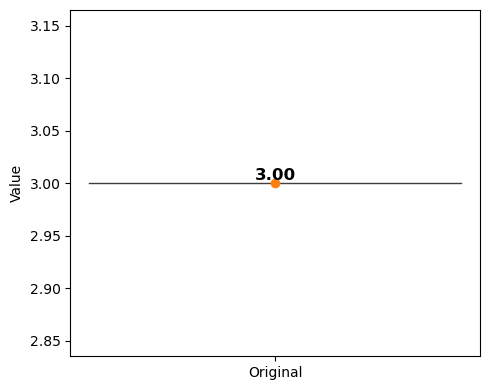

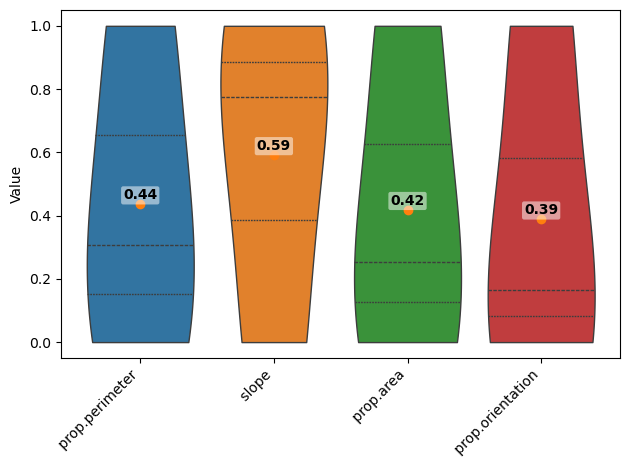

In [ ]:
from sklearn.preprocessing import MinMaxScaler


dffeaturesall = dffeaturesreal


vp = violinplt(featurescounted[["Original"]], figsize=(5, 4))


scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeaturesall_norm = dffeaturesall[columnstonormalize]
dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)
fig = violinplt(
    dffeaturesall_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)
# fig.savefig("violins.png", bbox_inches="tight")

## Step 9: PVImage stats for many images

In [ ]:
m_idx = len(val_loader.dataset)  # indices to process
masks = []
impaths = []

for i in range(m_idx):
    img, _ = val_loader.dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_loader.dataset.__get_img_path__(i)

    # model inference
    logits = model(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks.append(crack_mask)
    impaths.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
dfinfo_multi = pd.DataFrame({"impath": impaths})

# Run PVImage feature extraction across all predicted crack masks
dffeatures_multi = features.feature_extraction_crack_mask(masks, dfinfo_multi)
print(
    f"Processed {len(masks)} ground-truth images, extracted {len(dffeatures_multi)} feature rows."
)
display(dffeatures_multi.head())

Processed 585 ground-truth images, extracted 601 feature rows.


,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_sa19965_sub_EL_9,2,271.740115,-0.298467,2296.0,1497.0,-0.486834
0,mxy_sa19965_sub_EL_9,8,266.468037,-0.155785,1826.0,1403.0,-0.386939
0,mxy_sa19965_sub_EL_9,4,235.39697,-1.476617,2109.0,1289.0,-1.394845
0,mxy_sa19965_sub_EL_9,5,233.39697,0.500036,2353.0,1422.0,0.739917
0,SW2,1,157.556349,1.625017,887.0,789.0,1.500654


In [ ]:
dffeatures_multi["count_features"] = dffeatures_multi.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeatures_multi_count = dffeatures_multi.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
dffeatures_multi_count.reset_index(drop=True, inplace=True)

featurescounted_multi = pd.concat(
    [dffeatures_multi_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_multi.columns = ["Original"]

# Show basic outputs
print(f"Processed {len(masks)} images, extracted {len(dffeatures_multi)} feature rows.")
display(featurescounted_multi.head())

Processed 585 images, extracted 601 feature rows.


,Original
0,1
1,2
2,1
3,3
4,3


In [ ]:
dffeatures_multi.to_pickle("mms_dffeatures.pickle")
dffeatures_multi = pd.read_pickle("mms_dffeatures.pickle")

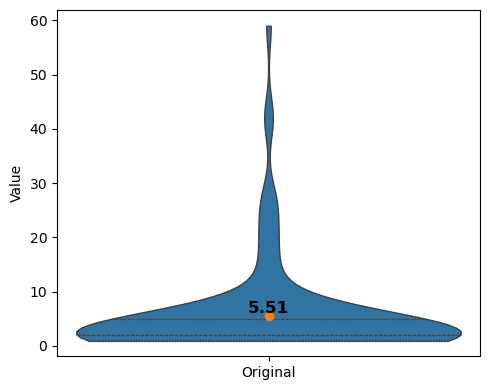

In [ ]:
vp = violinplt(featurescounted_multi[["Original"]], figsize=(5, 4))

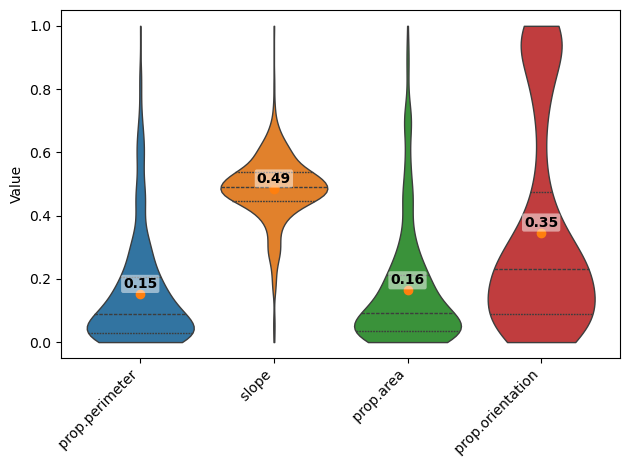

In [ ]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_multi_norm = dffeatures_multi[columnstonormalize]
dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)
fig = violinplt(
    dffeatures_multi_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)

## Step 10: PVImage stats for ground truth crack masks

In [ ]:
gt_masks = []
gt_impaths = []

for i in range(m_idx):
    _, gt_mask = val_loader.dataset.__getitem__(i)
    img_path = val_loader.dataset.__get_img_path__(i)

    crack_mask_gt = (gt_mask.cpu().numpy()[2] * 255).astype(np.uint8)

    gt_masks.append(crack_mask_gt)
    gt_impaths.append(str(img_path))

dfinfo_gt = pd.DataFrame({"impath": gt_impaths})
dffeatures_gt = features.feature_extraction_crack_mask(gt_masks, dfinfo_gt)


display(dffeatures_gt.head())

,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_sa19965_sub_EL_9,7,214.083261,-1.170103,1893.0,1167.0,-1.370287
0,mxy_sa19965_sub_EL_9,14,206.325902,-0.380381,1568.0,1059.0,-1.052619
0,mxy_sa19965_sub_EL_9,4,162.426407,-0.890218,1256.0,887.0,-0.862461
0,SW2,3,119.313708,1.319687,616.0,546.0,1.455919
0,my_SW1,0,454.575685,-0.897546,5464.0,2804.0,-0.985487


In [ ]:
dffeatures_gt["count_features"] = dffeatures_gt.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeatures_gt_count = dffeatures_gt.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
dffeatures_gt_count.reset_index(drop=True, inplace=True)

featurescounted_gt = pd.concat(
    [dffeatures_gt_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_gt.columns = ["Ground Truth"]

display(featurescounted_gt.head())
print(
    f"Processed {len(gt_masks)} ground-truth images, extracted {len(dffeatures_gt)} feature rows."
)

,Ground Truth
0,1
1,2
2,1
3,4
4,4


Processed 585 ground-truth images, extracted 590 feature rows.


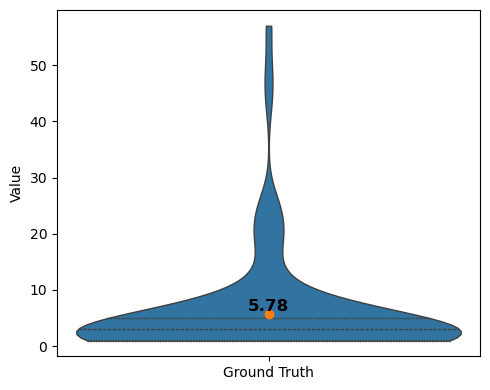

In [ ]:
vp = violinplt(featurescounted_gt[["Ground Truth"]], figsize=(5, 4))


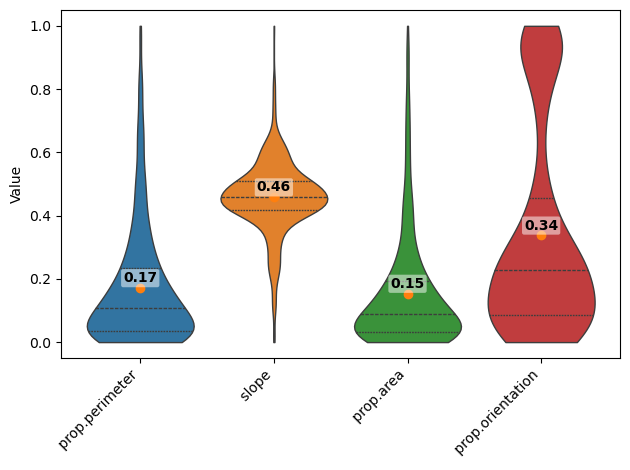

In [ ]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_gt_norm = dffeatures_gt[columnstonormalize]
dffeatures_gt_norm[columnstonormalize] = scaler.fit_transform(dffeatures_gt_norm)
fig = violinplt(
    dffeatures_gt_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)

## Step 11: Compare PVImage stats (predicted vs. ground truth)

Join the PVImage outputs to see how the model's crack counts and shape metrics differ from the labeled data.


In [ ]:
pred_counts = dffeatures_multi.groupby("cell_number").size().rename("pred_crack_count")
gt_counts = dffeatures_gt.groupby("cell_number").size().rename("gt_crack_count")

count_comparison = (
    pd.concat([pred_counts, gt_counts], axis=1).fillna(0).astype(int).reset_index()
)
count_comparison.columns = ["cell_number", "pred_crack_count", "gt_crack_count"]
count_comparison["count_diff"] = (
    count_comparison["pred_crack_count"] - count_comparison["gt_crack_count"]
)

display(count_comparison.head())


,cell_number,pred_crack_count,gt_crack_count,count_diff
0,0563,1,1,0
1,0774,2,2,0
2,0809,1,1,0
3,0_EL_18.09.2023,3,4,-1
4,1090,3,4,-1


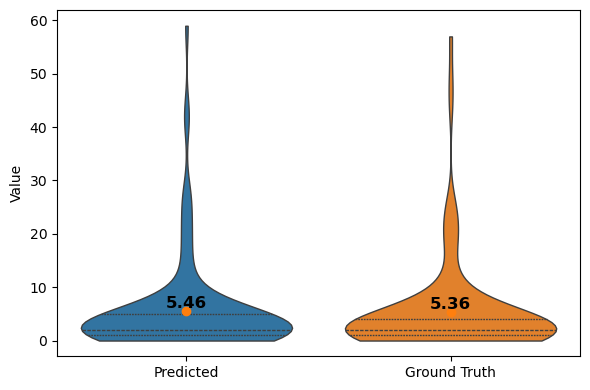

In [ ]:
vp = violinplt(
    count_comparison[["pred_crack_count", "gt_crack_count"]].rename(
        columns={
            "pred_crack_count": "Predicted",
            "gt_crack_count": "Ground Truth",
        }
    ),
    figsize=(6, 4),
)


In [ ]:
feature_cols = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
feature_comparison = pd.DataFrame(
    {
        "Predicted_mean": dffeatures_multi_norm[feature_cols].mean(),
        "GroundTruth_mean": dffeatures_gt_norm[feature_cols].mean(),
    }
)
feature_comparison["abs_diff"] = (
    feature_comparison["Predicted_mean"] - feature_comparison["GroundTruth_mean"]
).abs()
feature_comparison


,Predicted_mean,GroundTruth_mean,abs_diff
prop.perimeter,0.151889,0.170860,0.018971
slope,0.485083,0.457917,0.027167
prop.area,0.163280,0.153094,0.010186
prop.orientation,0.345932,0.337139,0.008792


,Predicted prop.perimeter,Ground Truth prop.perimeter,Predicted slope,Ground Truth slope,Predicted prop.area,Ground Truth prop.area,Predicted prop.orientation,Ground Truth prop.orientation
0,0.078961,0.057378,0.517969,0.420981,0.077577,0.047678,0.344652,0.063179
1,0.076532,0.053472,0.528462,0.483016,0.070977,0.041025,0.376496,0.164383
2,0.062214,0.031365,0.431319,0.442967,0.062974,0.030430,0.055206,0.224965
3,0.061292,0.009654,0.576696,0.616562,0.072311,0.009425,0.735703,0.963567
4,0.026345,0.178485,0.659435,0.442391,0.027871,0.148515,0.978202,0.185770
...,...,...,...,...,...,...,...,...
596,0.000177,NaN,0.475078,NaN,0.009407,NaN,0.201521,NaN
597,0.120884,NaN,0.463893,NaN,0.148343,NaN,0.233929,NaN
598,0.086195,NaN,0.501708,NaN,0.098568,NaN,0.284622,NaN
599,0.096668,NaN,0.521463,NaN,0.103131,NaN,0.054135,NaN


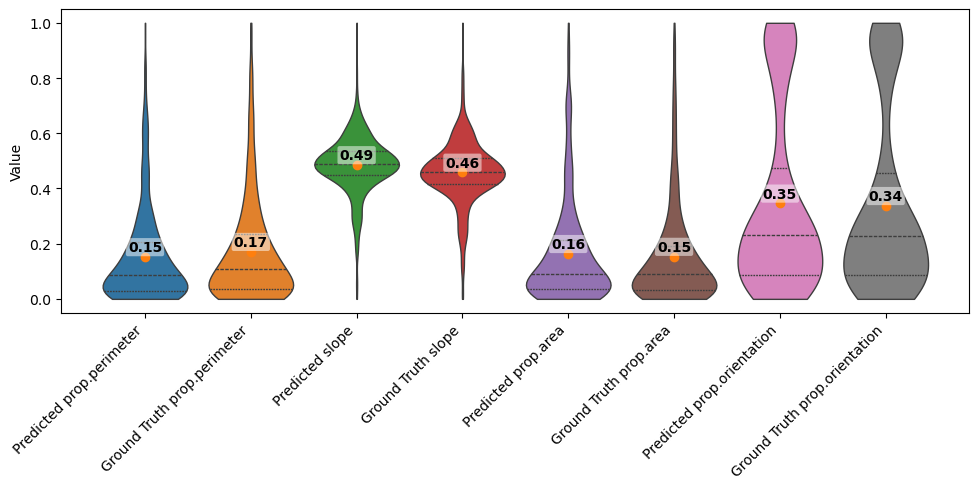

In [ ]:
feature_pairs = []

for col in feature_cols:
    if (
        col not in dffeatures_multi_norm.columns
        or col not in dffeatures_gt_norm.columns
    ):
        print(f"Skipping {col}: not found in features dataframe.")
        continue

    label = col.strip()
    pred = dffeatures_multi_norm[col].reset_index(drop=True)
    gt = dffeatures_gt_norm[col].reset_index(drop=True)

    max_len = max(len(pred), len(gt))
    if max_len == 0:
        print(f"Skipping {label}: no data to plot.")
        continue

    pred = pred.reindex(range(max_len))
    gt = gt.reindex(range(max_len))

    feature_pairs.append(
        pd.DataFrame(
            {
                f"Predicted {label}": pred,
                f"Ground Truth {label}": gt,
            }
        )
    )

if not feature_pairs:
    print("No feature data available for violin plots.")
    feature_violin_df = pd.DataFrame()
else:
    feature_violin_df = pd.concat(feature_pairs, axis=1)
    feature_violin_df = feature_violin_df.apply(pd.to_numeric, errors="coerce")
    feature_violin_df = feature_violin_df.dropna(axis=1, how="all")

    if feature_violin_df.empty:
        print("No numeric feature data available for violin plots.")
    else:
        # Render comparison violins
        vp = violinplt(feature_violin_df, figsize=(10, 5))

feature_violin_df


## Do same for pv-vision

In [ ]:
#Load pv-vision model and weights
from tutorials.unet_model import construct_unet #this tutorial is from pv-vision
from torch.nn import DataParallel

device = torch.device('cpu')

# build & wrap
unet = construct_unet(5)
unet = DataParallel(unet)

# load the dict right out of the file — no prefixing
state_dict = torch.load('unet_oversample_low_final_model_for_paper/model.pt',
                        map_location=device)

unet.load_state_dict(state_dict)
model_pvvision = unet.module.to(device)

In [ ]:
category_mapping = {
                  0 : 'dark',
                  1 : 'busbar',
                  2 : 'crack',
                  3 : 'cross'} #I think this is the third category "x-cracks"

idx = 7
threshold = 0.5  # default

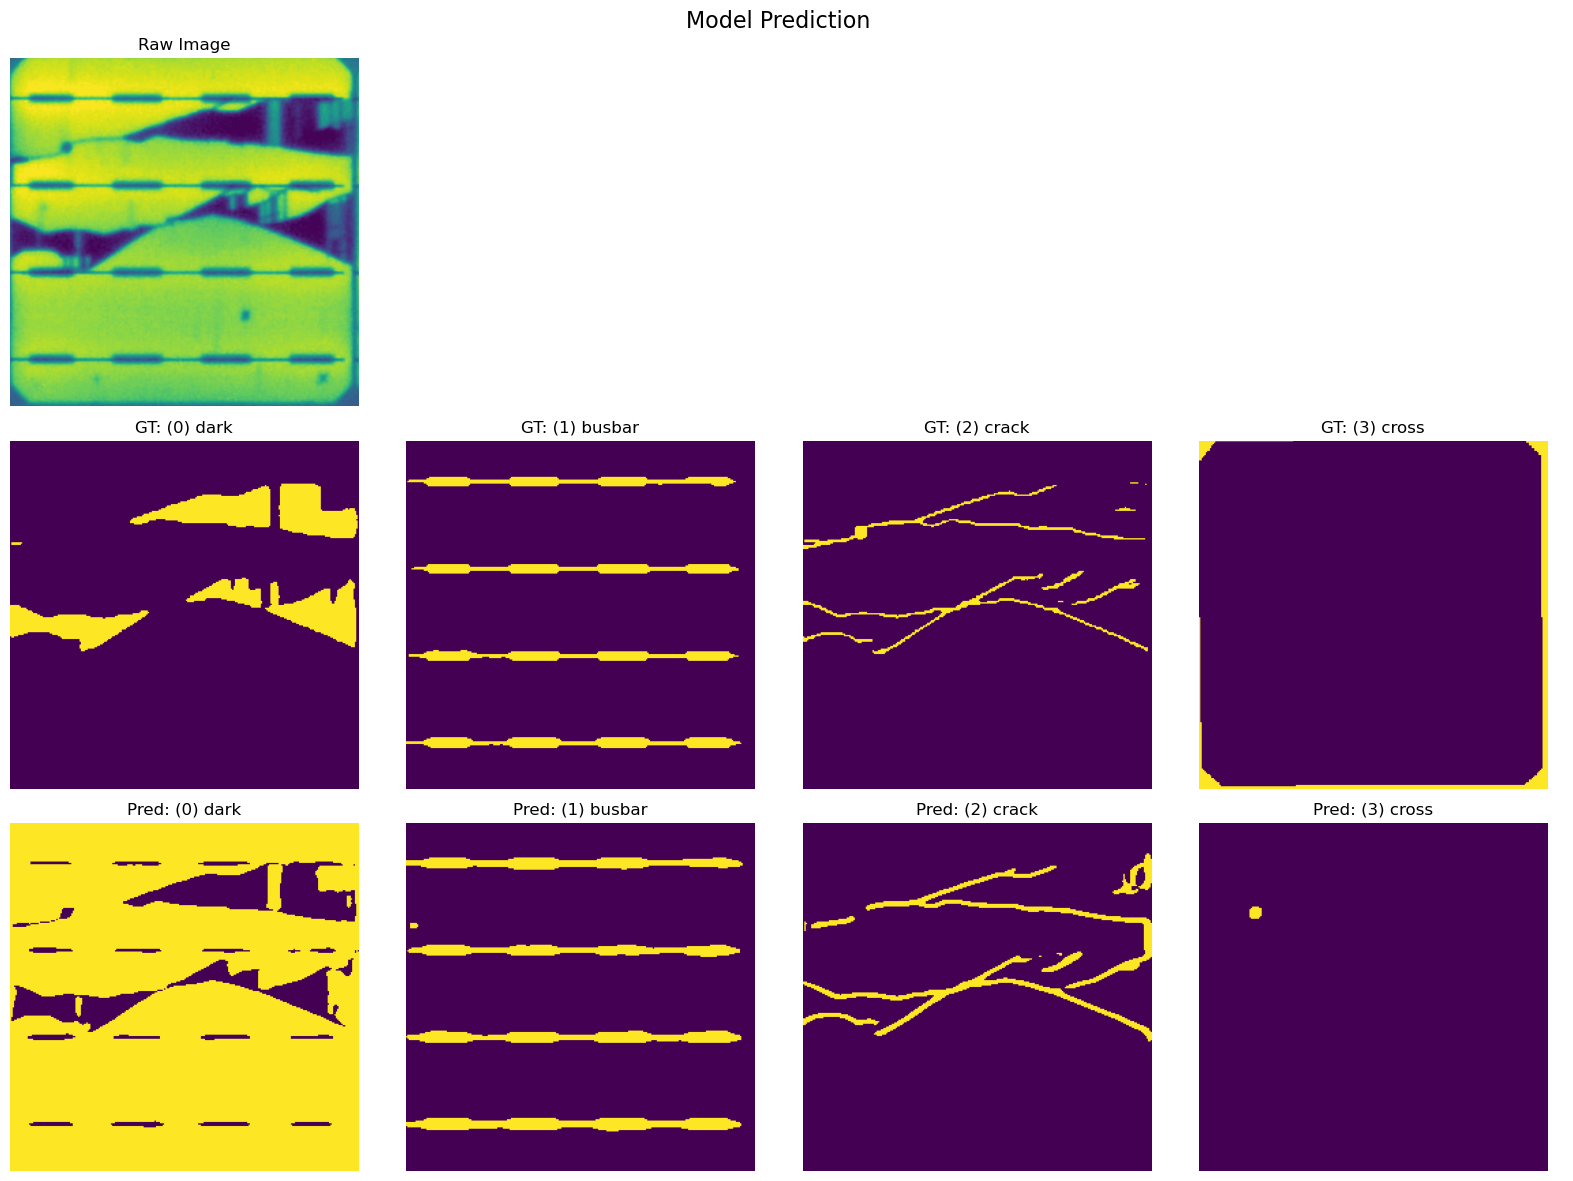

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_functions.channeled_inference_and_show(
    val_loader, device=device, model=model_pvvision, category_mapping= category_mapping, idx=idx, threshold=0.5, custom_title="PV-Vision Model Prediction"
)
plt.savefig("pvvision_model_prediction.png", dpi=300)

In [ ]:
#All images
m_idx = len(val_loader.dataset)  # indices to process
masks = []
impaths = []

for i in range(m_idx):
    img, _ = val_loader.dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_loader.dataset.__get_img_path__(i)

    # model inference
    logits = model_pvvision(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks.append(crack_mask)
    impaths.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
dfinfo_multi = pd.DataFrame({"impath": impaths})

# Run PVImage feature extraction across all predicted crack masks
dffeatures_multi_pvvision = features.feature_extraction_crack_mask(masks, dfinfo_multi)
print(
    f"Processed {len(masks)} ground-truth images, extracted {len(dffeatures_multi)} feature rows."
)
display(dffeatures_multi_pvvision.head())

dffeatures_multi_pvvision["count_features"] = dffeatures_multi_pvvision.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeatures_multi_count = dffeatures_multi_pvvision.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
dffeatures_multi_count.reset_index(drop=True, inplace=True)

featurescounted_multi = pd.concat(
    [dffeatures_multi_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_multi.columns = ["Original"]

# Show basic outputs
print(f"Processed {len(masks)} images, extracted {len(dffeatures_multi)} feature rows.")
display(featurescounted_multi.head())


dffeatures_multi_pvvision.to_pickle("pvvision_dffeatures.pickle")
dffeatures_multi_pvvision = pd.read_pickle("pvvision_dffeatures.pickle")

Processed 585 ground-truth images, extracted 572 feature rows.


,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_sa19965_sub_EL_9,1,552.83557,-0.524613,7743.0,3487.0,-0.699696
0,mxy_sa19965_sub_EL_9,4,198.325902,-0.461665,1710.0,1447.0,-0.683089
0,SW2,0,153.59798,-0.985689,1174.0,924.0,-1.113709
0,SW2,10,127.313708,0.557848,809.0,630.0,1.319049
0,SW2,2,115.213203,0.222527,666.0,580.0,0.33296


Processed 585 images, extracted 572 feature rows.


,Original
0,1
1,2
2,1
3,2
4,9


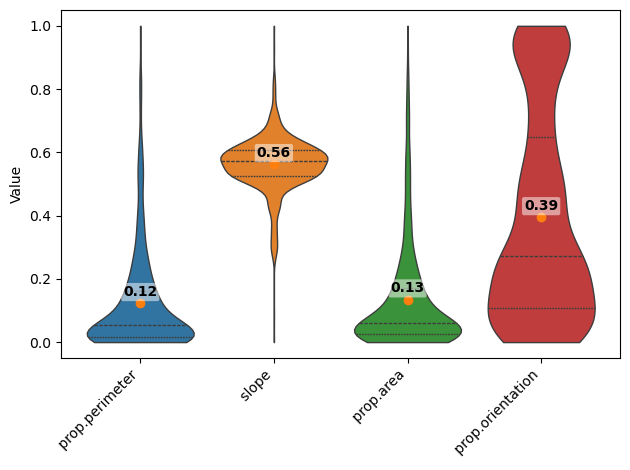

In [ ]:
#Add ground truth
pred_counts = dffeatures_multi_pvvision.groupby("cell_number").size().rename("pred_crack_count")
gt_counts = dffeatures_gt.groupby("cell_number").size().rename("gt_crack_count")

count_comparison = (
    pd.concat([pred_counts, gt_counts], axis=1).fillna(0).astype(int).reset_index()
)
count_comparison.columns = ["cell_number", "pred_crack_count", "gt_crack_count"]
count_comparison["count_diff"] = (
    count_comparison["pred_crack_count"] - count_comparison["gt_crack_count"]
)

scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_multi_norm = dffeatures_multi_pvvision[columnstonormalize]
dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)
fig = violinplt(
    dffeatures_multi_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)

Text(0.5, 1.0, 'pv-vision')

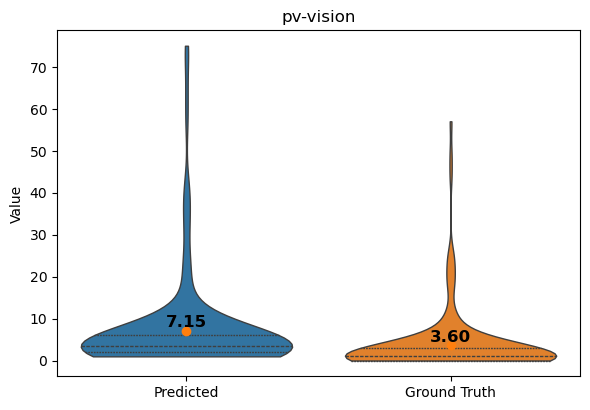

In [ ]:
vp = violinplt(
    count_comparison[["pred_crack_count", "gt_crack_count"]].rename(
        columns={
            "pred_crack_count": "Predicted",
            "gt_crack_count": "Ground Truth",
        }
    ),
    figsize=(6, 4),
)
plt.title("pv-vision")

In [ ]:
feature_cols = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
feature_comparison = pd.DataFrame(
    {
        "Predicted_mean": dffeatures_multi_norm[feature_cols].mean(),
        "GroundTruth_mean": dffeatures_gt_norm[feature_cols].mean(),
    }
)
feature_comparison["abs_diff"] = (
    feature_comparison["Predicted_mean"] - feature_comparison["GroundTruth_mean"]
).abs()
feature_comparison


,Predicted_mean,GroundTruth_mean,abs_diff
prop.perimeter,0.122926,0.170860,0.047934
slope,0.562446,0.457917,0.104529
prop.area,0.134435,0.153094,0.018659
prop.orientation,0.394483,0.337139,0.057343


,Predicted prop.perimeter,Ground Truth prop.perimeter,Predicted slope,Ground Truth slope,Predicted prop.area,Ground Truth prop.area,Predicted prop.orientation,Ground Truth prop.orientation
0,0.224055,0.057378,0.551249,0.420981,0.216021,0.047678,0.277144,0.063179
1,0.048634,0.053472,0.556411,0.483016,0.075988,0.041025,0.282431,0.164383
2,0.026501,0.031365,0.513440,0.442967,0.040088,0.030430,0.145335,0.224965
3,0.013495,0.009654,0.640013,0.616562,0.019907,0.009425,0.919853,0.963567
4,0.007507,0.178485,0.612516,0.442391,0.016474,0.148515,0.605911,0.185770
...,...,...,...,...,...,...,...,...
1168,0.018054,NaN,0.626138,NaN,0.036793,NaN,0.738026,NaN
1169,0.012385,NaN,0.602619,NaN,0.018808,NaN,0.542269,NaN
1170,0.001909,NaN,0.631208,NaN,0.006796,NaN,0.664104,NaN
1171,0.131226,NaN,0.599652,NaN,0.177993,NaN,0.994440,NaN


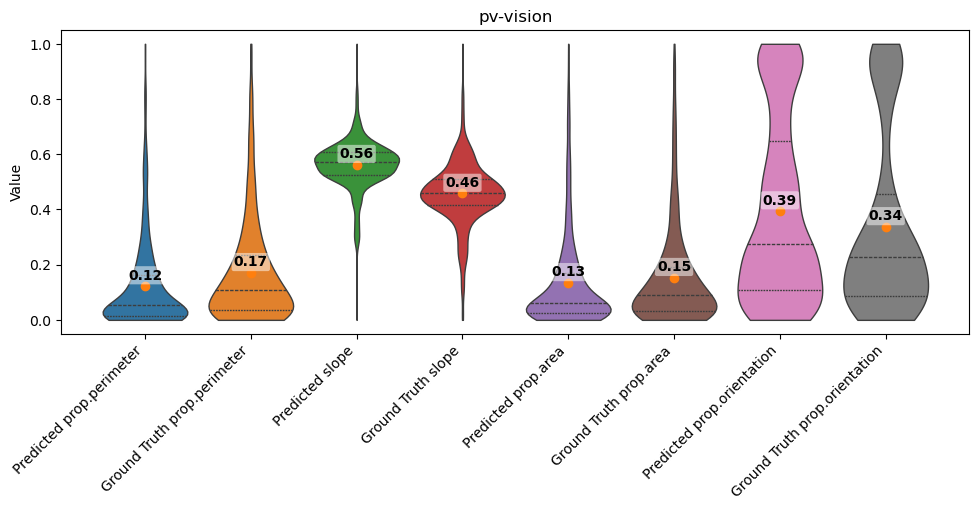

In [ ]:
feature_pairs = []

for col in feature_cols:
    if (
        col not in dffeatures_multi_norm.columns
        or col not in dffeatures_gt_norm.columns
    ):
        print(f"Skipping {col}: not found in features dataframe.")
        continue

    label = col.strip()
    pred = dffeatures_multi_norm[col].reset_index(drop=True)
    gt = dffeatures_gt_norm[col].reset_index(drop=True)

    max_len = max(len(pred), len(gt))
    if max_len == 0:
        print(f"Skipping {label}: no data to plot.")
        continue

    pred = pred.reindex(range(max_len))
    gt = gt.reindex(range(max_len))

    feature_pairs.append(
        pd.DataFrame(
            {
                f"Predicted {label}": pred,
                f"Ground Truth {label}": gt,
            }
        )
    )

if not feature_pairs:
    print("No feature data available for violin plots.")
    feature_violin_df = pd.DataFrame()
else:
    feature_violin_df = pd.concat(feature_pairs, axis=1)
    feature_violin_df = feature_violin_df.apply(pd.to_numeric, errors="coerce")
    feature_violin_df = feature_violin_df.dropna(axis=1, how="all")

    if feature_violin_df.empty:
        print("No numeric feature data available for violin plots.")
    else:
        # Render comparison violins
        vp = violinplt(feature_violin_df, figsize=(10, 5))
        plt.title("pv-vision")

feature_violin_df


## Other Benchmarking metrics

In [ ]:
# number of samples in the val set
m_idx = len(val_loader.dataset)

# prepare lists to collect results
impaths               = []
masks_multisolseg     = []
masks_pvvision        = []

for i in range(m_idx):
    # pull out the i-th sample and its path
    img, _      = val_loader.dataset[i]
    img         = img.to(device)
    img_path    = val_loader.dataset.__get_img_path__(i)
    
    impaths.append(str(img_path))

    # --- inference with multisolseg model ---
    with torch.no_grad():
        logits_ms = model(img.unsqueeze(0)).cpu()          # (1, n_classes, H, W)
        probs_ms  = torch.sigmoid(logits_ms)               # same shape
        pred_ms   = (probs_ms > threshold).float().squeeze(0).numpy()
    # extract crack channel #2, scale to [0,255]
    dark_ms = (pred_ms[0] * 255).astype(np.uint8)
    bb_ms = (pred_ms[1] * 255).astype(np.uint8)
    crack_ms = (pred_ms[2] * 255).astype(np.uint8)
    masks_multisolseg.append([dark_ms, bb_ms, crack_ms])

    # --- inference with pv-vision model ---
    with torch.no_grad():
        logits_pv = model_pvvision(img.unsqueeze(0)).cpu()
        probs_pv  = torch.sigmoid(logits_pv)
        pred_pv   = (probs_pv > threshold).float().squeeze(0).numpy()
    dark_pv = (pred_pv[0] * 255).astype(np.uint8)
    bb_pv = (pred_pv[1] * 255).astype(np.uint8)
    crack_pv = (pred_pv[2] * 255).astype(np.uint8)
    masks_pvvision.append([dark_pv, bb_pv, crack_pv])

In [ ]:
# number of samples in the val set (same as before)
m_idx = len(val_loader.dataset)

masks_gt = []
for i in range(m_idx):
    _, mask = val_loader.dataset[i]
    mask_np = mask.cpu().numpy()  # → shape (n_classes, H, W)

    dark_gt  = (mask_np[0] > 0).astype(np.uint8)  # bool→0/1→uint8
    bb_gt    = (mask_np[1] > 0).astype(np.uint8)
    crack_gt = (mask_np[2] > 0).astype(np.uint8)

    masks_gt.append([dark_gt, bb_gt, crack_gt])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ----------------------------------------------------------------------------
# helper to compute IoU on two boolean masks
def compute_iou(gt: np.ndarray, pred: np.ndarray) -> float:
    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    return float(inter) / union if union > 0 else 1.0

# class names and metric names
classes = ['dark', 'busbar', 'crack']
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Dice', 'IoU']

# sanity‐check lengths
assert len(masks_gt) == len(masks_multisolseg) == len(masks_pvvision)
M = len(masks_gt)

# prepare accumulators
results_ms = {c: {m: [] for m in metrics_names} for c in classes}
results_pv = {c: {m: [] for m in metrics_names} for c in classes}

for gt_triplet, ms_triplet, pv_triplet in zip(masks_gt,
                                              masks_multisolseg,
                                              masks_pvvision):
    for ci, cname in enumerate(classes):
        # boolean masks
        gt_mask = gt_triplet[ci] > 0           # shape (H,W)
        ms_mask = ms_triplet[ci] > 0
        pv_mask = pv_triplet[ci] > 0

        # flatten to vectors for sklearn
        y_true = gt_mask.flatten()
        y_ms   = ms_mask.flatten()
        y_pv   = pv_mask.flatten()

        # MultisolSegment metrics
        results_ms[cname]['Accuracy'].append(
            accuracy_score(y_true, y_ms))
        results_ms[cname]['Precision'].append(
            precision_score(y_true, y_ms, zero_division=0))
        results_ms[cname]['Recall'].append(
            recall_score(y_true, y_ms, zero_division=0))
        results_ms[cname]['Dice'].append(
            f1_score(y_true, y_ms, zero_division=0))
        results_ms[cname]['IoU'].append(
            compute_iou(gt_mask, ms_mask))

        # PV-Vision metrics
        results_pv[cname]['Accuracy'].append(
            accuracy_score(y_true, y_pv))
        results_pv[cname]['Precision'].append(
            precision_score(y_true, y_pv, zero_division=0))
        results_pv[cname]['Recall'].append(
            recall_score(y_true, y_pv, zero_division=0))
        results_pv[cname]['Dice'].append(
            f1_score(y_true, y_pv, zero_division=0))
        results_pv[cname]['IoU'].append(
            compute_iou(gt_mask, pv_mask))

n_classes = len(classes)
n_metrics = len(metrics_names)

avg_ms = np.zeros((n_classes, n_metrics), dtype=float)
avg_pv = np.zeros_like(avg_ms)

for ci, cname in enumerate(classes):
    for mi, mname in enumerate(metrics_names):
        avg_ms[ci, mi] = np.mean(results_ms[cname][mname])
        avg_pv[ci, mi] = np.mean(results_pv[cname][mname])

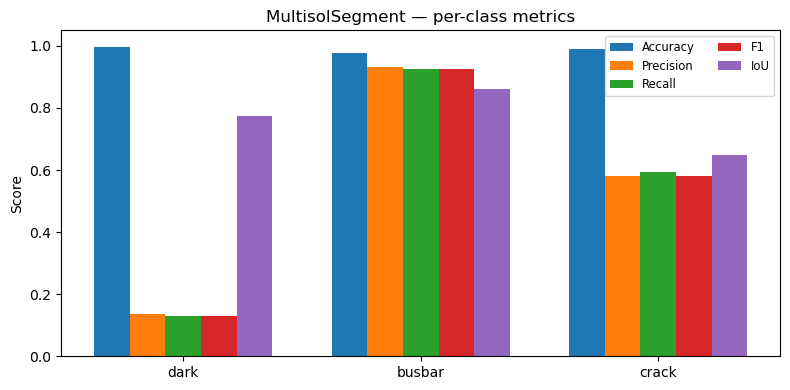

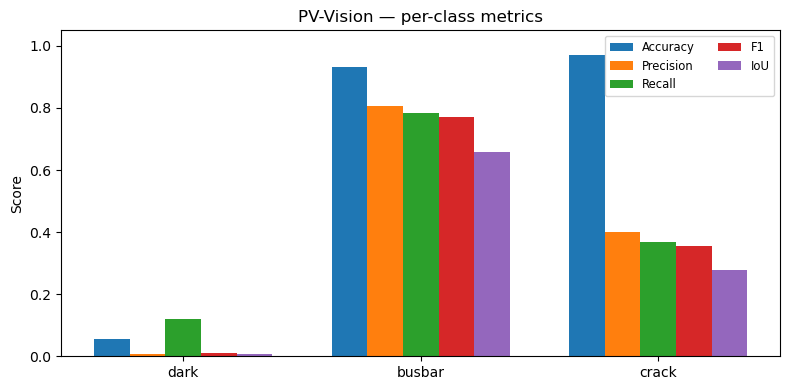

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, axes = plt.subplots(1, n_metrics, figsize=(20, 5), sharey=True)
if n_metrics == 1:
    axes = [axes]

x = np.arange(n_classes)
width = 0.35

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_names):
    ax = axes[i]
    
    # Get values for this metric across all classes
    ms_values = avg_ms[:, i]
    pv_values = avg_pv[:, i]
    
    rects1 = ax.bar(x - width/2, ms_values, width, label='MultiSolSegment', color='skyblue')
    rects2 = ax.bar(x + width/2, pv_values, width, label='PV-Vision', color='orange')
    
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    if i == 0:
        ax.set_ylabel('Score')
        # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()